In [109]:
#!pip install imbalanced-learn
# !pip install --upgrade scikit-learn imbalanced-learn
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import math
from sklearn.model_selection import train_test_split,KFold
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
#from imblearn.over_sampling import SMOTE
#!pip uninstall scikit-learn imbalanced-learn
#!pip install scikit-learn imbalanced-learn


In [110]:
datafile_train=r'/content/Consumer_Complaints_train.csv'
datafile_test=r'/content/Consumer_Complaints_test_share.csv'
cd_train=pd.read_csv(datafile_train)
cd_test=pd.read_csv(datafile_test)

In [111]:
cd_test.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Complaint ID
0,2014-01-18,Bank account or service,Cashing a check without an account,Deposits and withdrawals,NaN,NaN,NaN,Bank of America,CA,95691,NaN,NaN,Web,2014-01-17,Closed with explanation,Yes,675956
1,2016-03-31,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt was paid,NaN,NaN,"National Credit Adjusters, LLC",FL,32086,NaN,Consent not provided,Web,2016-03-31,Closed with explanation,Yes,1858795
2,2012-03-08,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,94618,NaN,NaN,Web,2012-03-09,Closed without relief,Yes,32637
3,2016-01-07,Credit reporting,NaN,Unable to get credit report/credit score,Problem getting report or credit score,NaN,Company chooses not to provide a public response,"TransUnion Intermediate Holdings, Inc.",FL,33584,Older American,NaN,Postal mail,2016-01-12,Closed with non-monetary relief,Yes,1731374
4,2013-08-23,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,FL,33543,NaN,NaN,Web,2013-08-23,Closed with explanation,Yes,501487


In [112]:
cd_train.dtypes

,0
Date received,object
Product,object
Sub-product,object
Issue,object
Sub-issue,object
Consumer complaint narrative,object
Company public response,object
Company,object
State,object
ZIP code,object


In [113]:
for col in ['Date received','Date sent to company']:
    cd_train[col]=pd.to_datetime(cd_train[col],infer_datetime_format=True)
    cd_test[col]=pd.to_datetime(cd_test[col],infer_datetime_format=True)

In [114]:
cd_train['day_diff']=pd.to_numeric(cd_train['Date sent to company']-cd_train['Date received'])
cd_test['day_diff']=pd.to_numeric(cd_test['Date sent to company']-cd_test['Date received'])

In [115]:
for col in ['Date received','Date sent to company']:
    cd_train.drop(columns=[col],inplace=True)
    cd_test.drop(columns=[col],inplace=True)

In [116]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
Sub-product : 47
Issue : 95
Sub-issue : 68
Consumer complaint narrative : 74019
Company public response : 10
Company : 3276
State : 62
ZIP code : 25962
Tags : 3
Consumer consent provided? : 4
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
Consumer disputed? : 2


In [117]:
cd_train.isnull().sum()

,0
Product,0
Sub-product,138473
Issue,0
Sub-issue,292625
Consumer complaint narrative,403327
Company public response,388029
Company,0
State,3839
ZIP code,3848
Tags,411215


In [118]:
len(pd.isnull(cd_train['Tags']))
len(cd_train)

478421

In [119]:
for col in ['Sub-product','Sub-issue','Consumer complaint narrative',
            'Company public response','Tags','Consumer consent provided?']:
    varname=col.replace('-','_').replace('?','').replace(" ",'_')+'_isNan'
    cd_train[varname]=np.where(pd.isnull(cd_train[col]),1,0)
    cd_train.drop(columns=[col],inplace=True)
    cd_test[varname]=np.where(pd.isnull(cd_test[col]),1,0)
    cd_test.drop(columns=[col],inplace=True)


In [120]:
cd_train.head(4)

,Product,Issue,Company,State,ZIP code,Submitted via,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,day_diff,Sub_product_isNan,Sub_issue_isNan,Consumer_complaint_narrative_isNan,Company_public_response_isNan,Tags_isNan,Consumer_consent_provided_isNan
0,Credit card,Billing statement,Wells Fargo & Company,MI,48342,Web,Closed with explanation,Yes,No,856103,86400000000000,1,1,1,1,0,1
1,Bank account or service,"Making/receiving payments, sending money",Santander Bank US,PA,18042,Referral,Closed,Yes,No,1034666,518400000000000,0,1,1,1,1,1
2,Credit reporting,Incorrect information on credit report,Equifax,CA,92427,Referral,Closed with non-monetary relief,Yes,No,756363,1814400000000000,1,0,1,1,1,1
3,Credit card,Billing statement,U.S. Bancorp,GA,305XX,Web,Closed with monetary relief,Yes,No,1474177,0,1,1,0,0,0,0


In [121]:
cd_train.columns

Index(['Product', 'Issue', 'Company', 'State', 'ZIP code', 'Submitted via',
       'Company response to consumer', 'Timely response?',
       'Consumer disputed?', 'Complaint ID', 'day_diff', 'Sub_product_isNan',
       'Sub_issue_isNan', 'Consumer_complaint_narrative_isNan',
       'Company_public_response_isNan', 'Tags_isNan',
       'Consumer_consent_provided_isNan'],
      dtype='object')

In [122]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
Issue : 95
Company : 3276
State : 62
ZIP code : 25962
Submitted via : 6
Company response to consumer : 7
Timely response? : 2
Consumer disputed? : 2


In [123]:
# try:
#     cd_train.drop(columns=['ZIP code'], inplace=True)
# except KeyError as e:
#     print(e)

In [124]:
for col in ['ZIP code','Company']:
    cd_train.drop(columns=[col],inplace=True)
    cd_test.drop(columns=[col],inplace=True)


In [125]:
# y['Consumer disputed']= cd_train['Consumer disputed?']
# print(y)
#y.isnull().sum()
y_train=pd.DataFrame()
y_train['Consumer disputed?']=cd_train['Consumer disputed?']  #need to convert numpy array in panda dataframe
#y_train = pd.DataFrame(y,columns=['Consumer disputed?'])
y_train
# Convert to DataFrame with column names
#df_with_columns = pd.DataFrame(data, columns=['A', 'B', 'C'])

,Consumer disputed?
0,No
1,No
2,No
3,No
4,No
...,...
478416,No
478417,No
478418,No
478419,No


In [126]:
# Convert 'churn' column from 'Yes'/'No' to 1/0
label_encoder = LabelEncoder()
y_train['Consumer disputed'] = label_encoder.fit_transform(y_train['Consumer disputed?'])
#df['Target'] = label_encoder.fit_transform(df['Category'])

In [127]:
# Example for one-hot encoding categorical features
y_train= pd.get_dummies(y_train ,columns=['Consumer disputed?'], drop_first=True)  # Converts categorical features to numerical
print(y_train)

        Consumer disputed  Consumer disputed?_Yes
0                       0                   False
1                       0                   False
2                       0                   False
3                       0                   False
4                       0                   False
...                   ...                     ...
478416                  0                   False
478417                  0                   False
478418                  0                   False
478419                  0                   False
478420                  0                   False

[478421 rows x 2 columns]


In [128]:
y_train.columns
del y_train['Consumer disputed?_Yes']

In [129]:
#cd_train['Consumer disputed?']=np.where(cd_train['Consumer disputed?']=="Yes",1,0)
#x=cd_train
#x=cd_train.drop(columns='Consumer disputed?',inplace=True)
del cd_train['Consumer disputed?']
#x.isnull().sum()
cd_train

,Product,Issue,State,Submitted via,Company response to consumer,Timely response?,Complaint ID,day_diff,Sub_product_isNan,Sub_issue_isNan,Consumer_complaint_narrative_isNan,Company_public_response_isNan,Tags_isNan,Consumer_consent_provided_isNan
0,Credit card,Billing statement,MI,Web,Closed with explanation,Yes,856103,86400000000000,1,1,1,1,0,1
1,Bank account or service,"Making/receiving payments, sending money",PA,Referral,Closed,Yes,1034666,518400000000000,0,1,1,1,1,1
2,Credit reporting,Incorrect information on credit report,CA,Referral,Closed with non-monetary relief,Yes,756363,1814400000000000,1,0,1,1,1,1
3,Credit card,Billing statement,GA,Web,Closed with monetary relief,Yes,1474177,0,1,1,0,0,0,0
4,Credit card,Transaction issue,MA,Web,Closed with explanation,Yes,1132572,691200000000000,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478416,Bank account or service,Problems caused by my funds being low,TX,Phone,Closed with explanation,Yes,1445488,86400000000000,0,1,1,1,1,1
478417,Credit card,Collection practices,AL,Phone,Closed with explanation,Yes,438011,86400000000000,1,1,1,1,1,1
478418,Credit reporting,Incorrect information on credit report,TX,Web,Closed with explanation,Yes,1020651,0,1,0,1,1,1,1
478419,Mortgage,"Loan modification,collection,foreclosure",CA,Web,Closed with explanation,Yes,157524,259200000000000,0,1,1,1,1,1


In [130]:
k=cd_train['Issue'].value_counts()
for val in k.axes[0][0:10]:
    varname='Issue_'+val.replace(',','_').replace(' ','_')
    cd_train[varname]=np.where(cd_train['Issue']==val,1,0)
    cd_test[varname]=np.where(cd_test['Issue']==val,1,0)
del cd_train['Issue']
del cd_test['Issue']

In [131]:
for col in cd_train.select_dtypes(['object']).columns:
    print(col,':',cd_train[col].nunique())

Product : 12
State : 62
Submitted via : 6
Company response to consumer : 7
Timely response? : 2


In [132]:
k=cd_train['State'].value_counts()
for val in k.axes[0][0:15]:
    varname='State_'+val.replace(',','_').replace(' ','_')
    cd_train[varname]=np.where(cd_train['State']==val,1,0)
    cd_test[varname]=np.where(cd_test['State']==val,1,0)
del cd_train['State']
del cd_test['State']

In [133]:
for col in ['Product','Submitted via','Company response to consumer','Timely response?']:

    temp=pd.get_dummies(cd_train[col],prefix=col,drop_first=True)
    cd_train=pd.concat([temp,cd_train],axis=1)
    cd_train.drop(columns=[col],inplace=True)

    temp=pd.get_dummies(cd_test[col],prefix=col,drop_first=True)
    cd_test=pd.concat([temp,cd_test],axis=1)
    cd_test.drop(columns=[col],inplace=True)


In [134]:
cd_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119606 entries, 0 to 119605
Data columns (total 56 columns):
 #   Column                                                        Non-Null Count   Dtype
---  ------                                                        --------------   -----
 0   Timely response?_Yes                                          119606 non-null  bool 
 1   Company response to consumer_Closed with explanation          119606 non-null  bool 
 2   Company response to consumer_Closed with monetary relief      119606 non-null  bool 
 3   Company response to consumer_Closed with non-monetary relief  119606 non-null  bool 
 4   Company response to consumer_Closed with relief               119606 non-null  bool 
 5   Company response to consumer_Closed without relief            119606 non-null  bool 
 6   Company response to consumer_Untimely response                119606 non-null  bool 
 7   Submitted via_Fax                                             119606 non-n

In [135]:
cd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478421 entries, 0 to 478420
Data columns (total 56 columns):
 #   Column                                                        Non-Null Count   Dtype
---  ------                                                        --------------   -----
 0   Timely response?_Yes                                          478421 non-null  bool 
 1   Company response to consumer_Closed with explanation          478421 non-null  bool 
 2   Company response to consumer_Closed with monetary relief      478421 non-null  bool 
 3   Company response to consumer_Closed with non-monetary relief  478421 non-null  bool 
 4   Company response to consumer_Closed with relief               478421 non-null  bool 
 5   Company response to consumer_Closed without relief            478421 non-null  bool 
 6   Company response to consumer_Untimely response                478421 non-null  bool 
 7   Submitted via_Fax                                             478421 non-n

In [136]:
del cd_train['Complaint ID']
cd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478421 entries, 0 to 478420
Data columns (total 55 columns):
 #   Column                                                        Non-Null Count   Dtype
---  ------                                                        --------------   -----
 0   Timely response?_Yes                                          478421 non-null  bool 
 1   Company response to consumer_Closed with explanation          478421 non-null  bool 
 2   Company response to consumer_Closed with monetary relief      478421 non-null  bool 
 3   Company response to consumer_Closed with non-monetary relief  478421 non-null  bool 
 4   Company response to consumer_Closed with relief               478421 non-null  bool 
 5   Company response to consumer_Closed without relief            478421 non-null  bool 
 6   Company response to consumer_Untimely response                478421 non-null  bool 
 7   Submitted via_Fax                                             478421 non-n

In [137]:
#!pip install imbalanced-learn

In [138]:
from imblearn.over_sampling import SMOTE
X_res,y_res =SMOTE().fit_resample(cd_train,y_train)

In [139]:
y_res.value_counts()

,count
Consumer disputed,
0,376990
1,376990


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [141]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [143]:
#y_test['Consumer disputed?_Yes']

In [144]:
y_test

,Consumer disputed
722925,1
394280,0
675249,1
98924,0
312879,0
...,...
669578,1
65221,0
79922,1
327247,0


In [145]:
X_train

array([[ 0.13255219,  0.60197968, -0.22815101, ..., -0.14254459,
        -0.13470516, -0.13007648],
       [ 0.13255219, -1.66118565, -0.22815101, ..., -0.14254459,
        -0.13470516, -0.13007648],
       [ 0.13255219,  0.60197968, -0.22815101, ..., -0.14254459,
        -0.13470516, -0.13007648],
       ...,
       [ 0.13255219,  0.60197968, -0.22815101, ..., -0.14254459,
        -0.13470516, -0.13007648],
       [ 0.13255219,  0.60197968, -0.22815101, ..., -0.14254459,
        -0.13470516, -0.13007648],
       [-7.54419846,  0.60197968, -0.22815101, ..., -0.14254459,
         7.42362038, -0.13007648]])

In [146]:
#from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [147]:
params={ 'class_weight':[None,'balanced'],
        'criterion':['entropy','gini'],
        'max_depth':[2,5,10,15,20,30,50,70],
        'min_samples_leaf':[1,2,5,10,15,20,30,50],
        'min_samples_split':[2,5,10,15,20,30,50]
       }

In [148]:
#clf=LogisticRegression()
clf=DecisionTreeClassifier()

In [149]:
random_search=RandomizedSearchCV(clf,
                                 cv=20,#*2*8*8*7*cv(2) this much cross-validation do
                                 param_distributions=params,#models parameter passing
                                 scoring='roc_auc',#matrix-evaluation
                                 n_iter=10,n_jobs=-1,verbose=20
                                    )

In [150]:
random_search.fit(X_train,y_train)

Fitting 20 folds for each of 10 candidates, totalling 200 fits


RandomizedSearchCV(cv=20, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': [None, 'balanced'],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 5, 10, 15, 20, 30, 50,
                                                      70],
                                        'min_samples_leaf': [1, 2, 5, 10, 15,
                                                             20, 30, 50],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30, 50]},
                   scoring='roc_auc', verbose=20)

In [151]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [152]:
#clf.fit(cd_train,y)
# from sklearn.metrics import classification_report,confusion_matrix
# from sklearn.metrics import roc_auc_score, roc_curve
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder

In [153]:
report(random_search.cv_results_,5)#give top results

Model with rank: 1
Mean validation score: 0.82504 (std: 0.00243)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_depth': 70, 'criterion': 'gini', 'class_weight': None}

Model with rank: 2
Mean validation score: 0.82503 (std: 0.00244)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 20, 'max_depth': 50, 'criterion': 'gini', 'class_weight': 'balanced'}

Model with rank: 3
Mean validation score: 0.82482 (std: 0.00230)
Parameters: {'min_samples_split': 20, 'min_samples_leaf': 15, 'max_depth': 30, 'criterion': 'gini', 'class_weight': None}

Model with rank: 4
Mean validation score: 0.82401 (std: 0.00233)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 30, 'max_depth': 70, 'criterion': 'gini', 'class_weight': 'balanced'}

Model with rank: 5
Mean validation score: 0.82400 (std: 0.00254)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 30, 'criterion': 'gini', 'class_weight': 'balanced'}



In [154]:
dtree = random_search.best_estimator_
dtree

DecisionTreeClassifier(max_depth=70, min_samples_leaf=20, min_samples_split=10)

In [156]:
#cd_test.columns
#cd_test.columns
#del cd_test['Complaint ID']

In [ ]:
#predictions.shape

In [ ]:
# array_1d = array_2d.reshape(-1)
# print(array_1d)
# array_1d = array_2d.ravel()
# print(array_1d)



In [ ]:
#y_test_1d =y_test.ravel()

In [157]:
#random_search.fit(cd_test,y)
predictions = dtree.predict(X_test)
#print(classification_report(y_test, predictions))
print(predictions)

[1 0 0 ... 1 0 1]


In [166]:
predictions.shape

(150796,)

In [160]:
y_test
y_test['Consumer disputed?_']=np.where(y_test['Consumer disputed']==True,1,0)

In [ ]:
#del y_test['Consumer disputed?_Yes']

In [163]:
del y_test['Consumer disputed?_']

In [164]:
y_test

,Consumer disputed
722925,1
394280,0
675249,1
98924,0
312879,0
...,...
669578,1
65221,0
79922,1
327247,0


In [167]:
predictions_1d=pd.DataFrame()

In [169]:
predictions_1d=pd.DataFrame(predictions,columns=['predictions'])
#del predictions_1d['column2']

In [ ]:
#del predictions_1d['column2']

In [170]:
accuracy = accuracy_score(y_test, predictions_1d)
print(f"Validation Accuracy Score: {accuracy:.4f}")
#print(classification_report(y_test, predictions))

Validation Accuracy Score: 0.7398


In [171]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [172]:
precision = precision_score(y_test, predictions_1d)
recall = recall_score(y_test, predictions_1d)
f1 = f1_score(y_test, predictions_1d)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Precision: 0.74
Recall: 0.74
F1 Score: 0.74


AUC Score: 0.7398


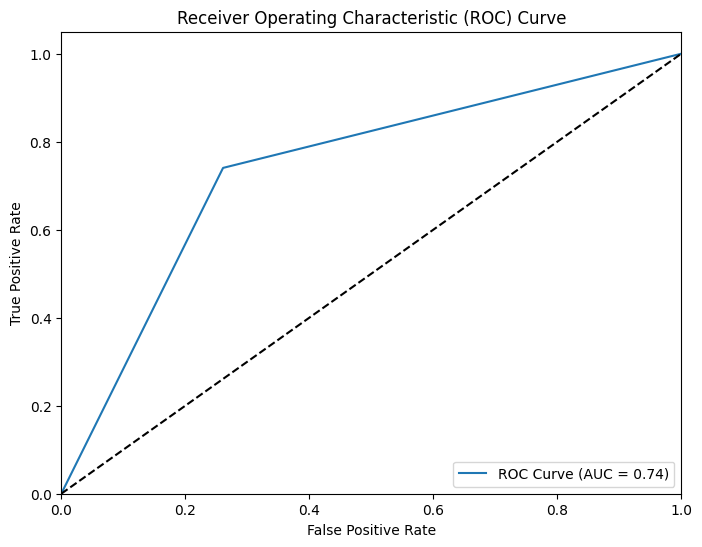

In [173]:
# Calculate AUC
auc_score = roc_auc_score(y_test, predictions_1d)
print(f"AUC Score: {auc_score:.4f}")

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_1d)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# prediction=np.where(clf.predict(cd_test.drop(columns=['Complaint ID']))==1,"Yes","No")
#  submission=pd.DataFrame(list(zip(y_test['Complaint ID'],list(predictions_1d))),
#                          columns=['Complaint ID','Consumer disputed?'])

In [174]:
y_test.head()

,Consumer disputed
722925,1
394280,0
675249,1
98924,0
312879,0


In [175]:
predictions_1d.head()

,predictions
0,1
1,0
2,0
3,1
4,1


In [176]:
submission1=pd.DataFrame()

In [177]:
submission1=np.where(predictions_1d['predictions']==1,'Yes','No',)
#labels = np.where(one_hot_encoded[:, 1] == 1, 'Yes', 'No')

In [178]:
#submission1 = pd.concat([y_test, predictions_1d], ignore_index=True)

In [179]:
submission1

array(['Yes', 'No', 'No', ..., 'Yes', 'No', 'Yes'], dtype='<U3')

In [181]:
submission1_=pd.DataFrame()

In [182]:
submission1_['Consumer disputed']=pd.DataFrame(submission1)
#del submission1_[0]


In [183]:
submission1_

,Consumer disputed
0,Yes
1,No
2,No
3,Yes
4,Yes
...,...
150791,Yes
150792,No
150793,Yes
150794,No


In [184]:
y_test
y_test=np.where(y_test['Consumer disputed']==1,'Yes','No',)

In [185]:
submission2_=pd.DataFrame()
submission2_['Consumer disputed']=pd.DataFrame(y_test)

In [186]:
submission2_

,Consumer disputed
0,Yes
1,No
2,Yes
3,No
4,No
...,...
150791,Yes
150792,No
150793,Yes
150794,No


In [187]:
#submission=pd.concat([submission1_,submission2_],axis=1)

In [188]:
#submission
submission1_['Complaint ID']=cd_test['Complaint ID']
submission1_

,Consumer disputed,Complaint ID
0,Yes,675956.0
1,No,1858795.0
2,No,32637.0
3,Yes,1731374.0
4,Yes,501487.0
...,...,...
150791,Yes,NaN
150792,No,NaN
150793,Yes,NaN
150794,No,NaN


In [190]:
submission1_.to_csv('sample_submissionfinal.csv',index=False)

This submission will get you auc score of approx 0.50, slightly less than whats required for passing the course. You'll have to make changes

In [ ]:
#df = pd.read_csv('C:\Users\VIVEK YADAV\Downloads\sample_submission (2).csv',on_bad_lines='skip')